In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as nnf
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

C:\Users\Nassim\AppData\Local\Temp\ipykernel_19340\1160388593.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\Nassim\AppData\Local\Temp\ipykernel_19340\1160388593.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    #Used to calculate the confusion matrix
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:

            Xd, yd = X.to(device), y.to(device)
            pred = model(Xd)
            
            test_loss += loss_fn(pred, yd).item()
            correct += (pred.argmax(1) == yd).type(torch.float).sum().item()
            
            
            y_pred.extend(pred.argmax(1).data.cpu().numpy())
            y_true.extend(y.data.cpu().numpy())

        

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()
    plt.xticks(rotation = 45) 
    plt.show()

loss_fn = nn.CrossEntropyLoss()

In [72]:
model = LeNet().to(device)
model.load_state_dict(torch.load("./model"))

<All keys matched successfully>

In [73]:
model_crop = LeNet().to(device)
model_crop.load_state_dict(torch.load("./model_crop"))

<All keys matched successfully>

In [74]:
model_retrained = LeNet().to(device)
model_retrained.load_state_dict(torch.load("./model_retrain"))

<All keys matched successfully>

In [75]:
model_retrained_crop = LeNet().to(device)
model_retrained_crop.load_state_dict(torch.load("./model_retrain_crop"))

<All keys matched successfully>

# Test Images entières

In [30]:
from torch.utils.data import random_split

path_pair_img = 'Photoshop/data/photoshoptest'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

_, test_data = random_split(dataset, [0.8, 0.2])
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size= 100, shuffle= False)

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.176452 



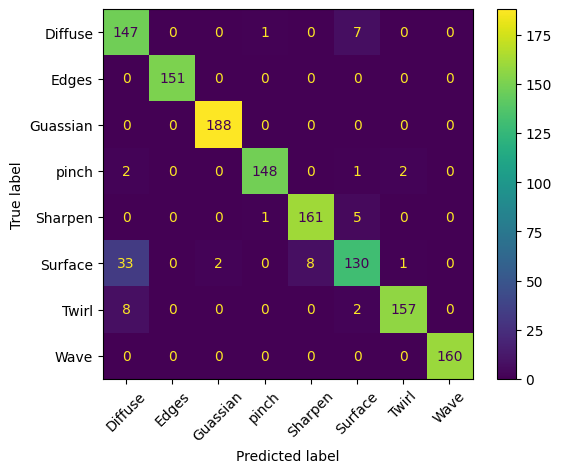

In [31]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 61.7%, Avg loss: 2.779394 



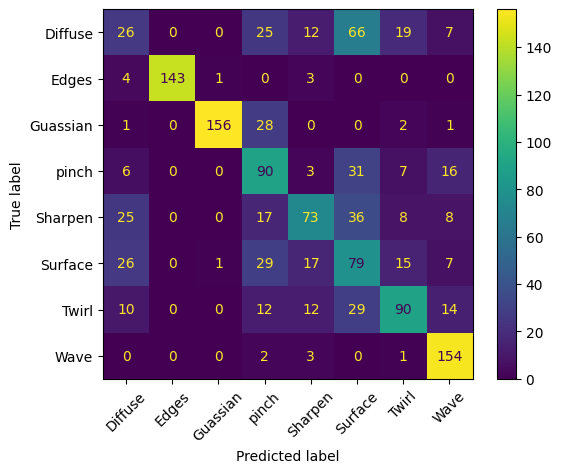

In [32]:
test(test_dataloader, model_crop, loss_fn)

# Test Images cropped

In [33]:
from torch.utils.data import random_split

path_pair_img_crop = 'Photoshop/data/photoshoptest_cropped'


dataset = datasets.ImageFolder(root=path_pair_img_crop, transform=image_transform)

_, test_data_crop = random_split(dataset, [0.96, 0.04])
test_dataloader_crop = torch.utils.data.DataLoader(test_data_crop, batch_size= 100, shuffle= False)

Test Error: 
 Accuracy: 32.6%, Avg loss: 5.432341 



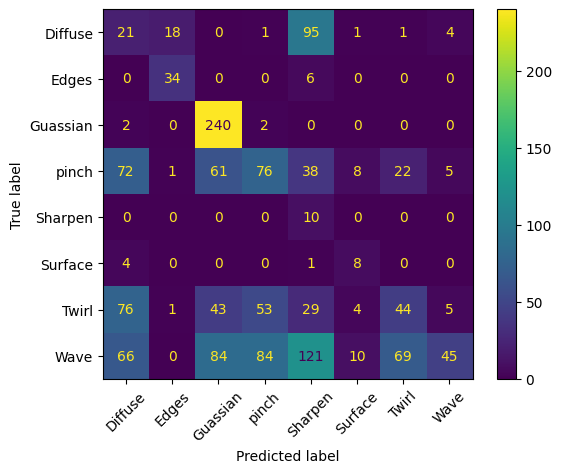

In [34]:
test(test_dataloader_crop, model, loss_fn)

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.460224 



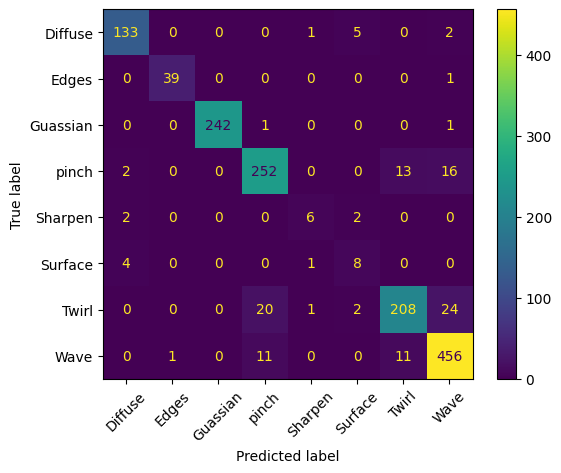

In [35]:
test(test_dataloader_crop, model_crop, loss_fn)

# Test combo 

In [36]:
import cv2
import numpy as np

def find_edited_areas(image1, image2, threshold=30, min_area=1000):
    diff_image = cv2.absdiff(image1, image2)
    gray_diff = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_diff = cv2.threshold(gray_diff, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]
    bounding_boxes = [cv2.boundingRect(contour) for contour in filtered_contours]
    return bounding_boxes


def bounding_box_from_points(points):
    x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

def find_bb(img_org, img_edt) : 
    image1 = img_org
    image2 = img_edt

    edited_areas = find_edited_areas(image1, image2, min_area=10)

    scale_factor = 1

    min_x = min_y = 100000
    max_x = max_y = 0

    images_list = []

    if len(edited_areas) > 0:
        for i, (x, y, w, h) in enumerate(edited_areas):
            scaled_w = int(w * scale_factor)
            scaled_h = int(h * scale_factor)
            scaled_x = max(0, int(x - (scaled_w - w) / 2))
            scaled_y = max(0, int(y - (scaled_h - h) / 2))

            cropped_image1 = image1[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            cropped_image2 = image2[scaled_y:scaled_y + scaled_h, scaled_x:scaled_x + scaled_w]
            
            final_image_cropped = np.hstack((cropped_image1, cropped_image2))
            images_list.append(final_image_cropped)
            
            if (min_x > scaled_x) : min_x = scaled_x
            if (min_y > scaled_y) : min_y = scaled_y
            if (max_x < scaled_x + scaled_w) : max_x = scaled_x + scaled_w 
            if (max_y < scaled_y + scaled_h) : max_y = scaled_y + scaled_h 


    else:
        return [np.hstack((image1, image2))]

    cropped_image1 = image1[min_y:max_y, min_x:max_x]
    cropped_image2 = image2[min_y:max_y, min_x:max_x]      
    final_image = np.hstack((cropped_image1, cropped_image2))
    images_list.append(final_image)
    return images_list



In [37]:
from torch.utils.data import random_split

path_pair_img = 'Photoshop/data/photoshoptest'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=None)

_, test_data = random_split(dataset, [0.8, 0.2])

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size= 100, shuffle= False)

y_true = []
y_pred = []

for img, y in test_data : 
    
    img_org, img_edt = np.hsplit(np.array(img), 2)
    
    final_imgs = find_bb(img_org, img_edt)
    
    class_small_bb = [0, 0, 0, 0, 0, 0, 0, 0]

    for final_img in final_imgs : 
        image_tensor = image_transform(Image.fromarray(final_img)).unsqueeze(0)
        image_tensor = image_tensor.cuda()

        with torch.no_grad() : 
            output = model_crop(image_tensor)
        _, predicted_class_crop = torch.max(output, 1)
        class_small_bb[predicted_class_crop] += 1
    
    predicted_class_crop = np.argmax(class_small_bb)

    image_tensor = image_transform(img).unsqueeze(0)
    image_tensor = image_tensor.cuda()
    with torch.no_grad() : 
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    if (predicted_class_crop == predicted_class) : 
        y_true.append(y)
        y_pred.append(predicted_class.item())


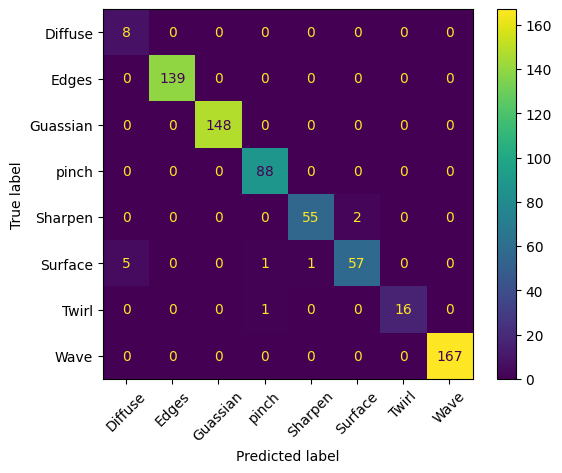

In [38]:
conf_matrix = confusion_matrix(y_true, y_pred)
labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.xticks(rotation = 45) 
plt.show()

 # Test handmade dataset

In [47]:
path_pair_img = 'Photoshop/data/photoshoptest_handmade'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size= 100, shuffle= False)

Test Error: 
 Accuracy: 43.8%, Avg loss: 7.171617 



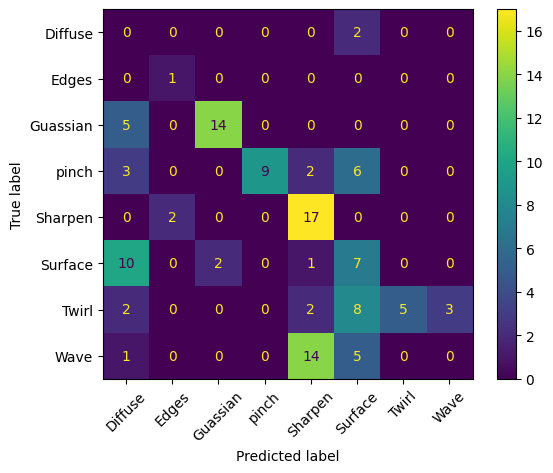

In [49]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 34.7%, Avg loss: 8.273379 



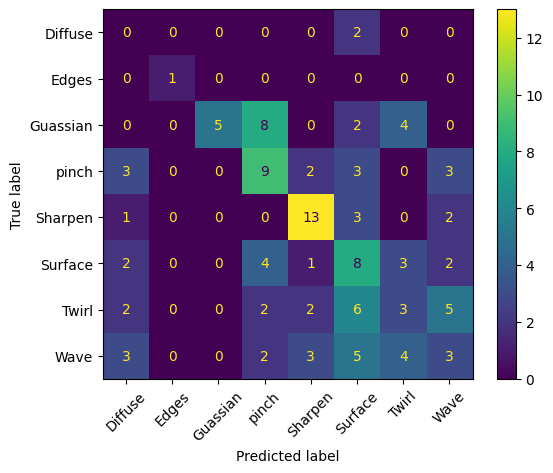

In [50]:
test(test_dataloader, model_crop, loss_fn)

Test Error: 
 Accuracy: 98.3%, Avg loss: 0.037438 



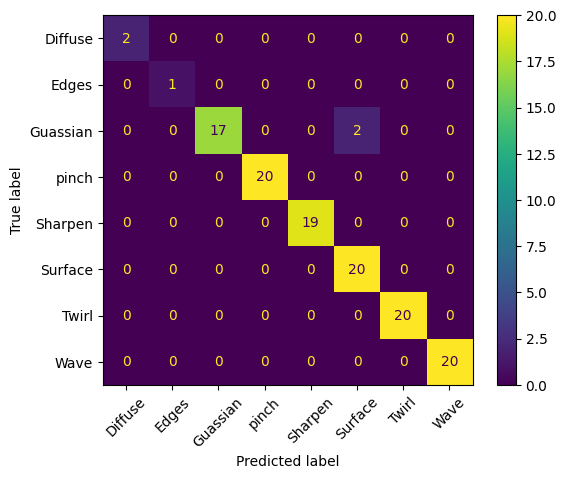

In [48]:
test(test_dataloader, model_retrained, loss_fn)

Test Error: 
 Accuracy: 47.9%, Avg loss: 4.148568 



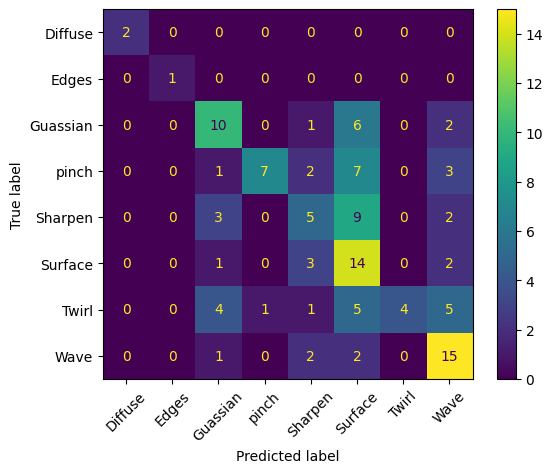

In [51]:
test(test_dataloader, model_retrained_crop, loss_fn)

# Test handmade dataset cropped

In [52]:
path_pair_img = 'Photoshop/data/photoshoptest_handmade_crop'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size= 100, shuffle= False)

Test Error: 
 Accuracy: 21.7%, Avg loss: 4.445374 



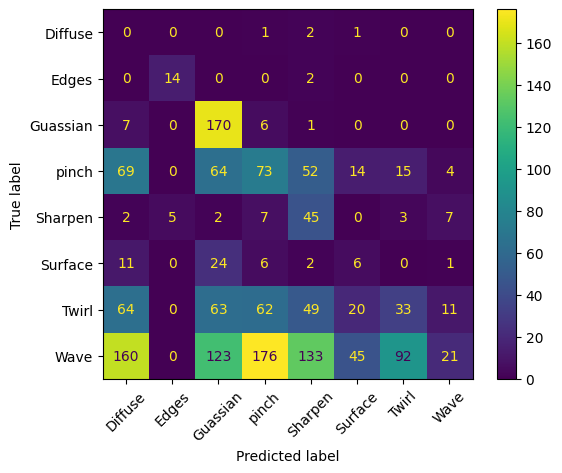

In [53]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 43.8%, Avg loss: 5.460302 



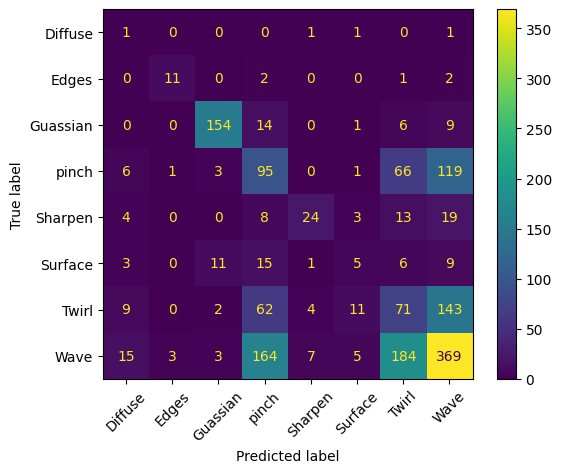

In [54]:
test(test_dataloader, model_crop, loss_fn)

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.827887 



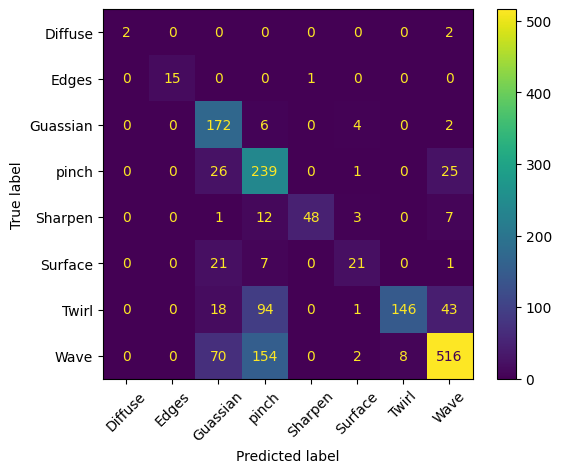

In [55]:
test(test_dataloader, model_retrained, loss_fn)

Test Error: 
 Accuracy: 96.9%, Avg loss: 0.167746 



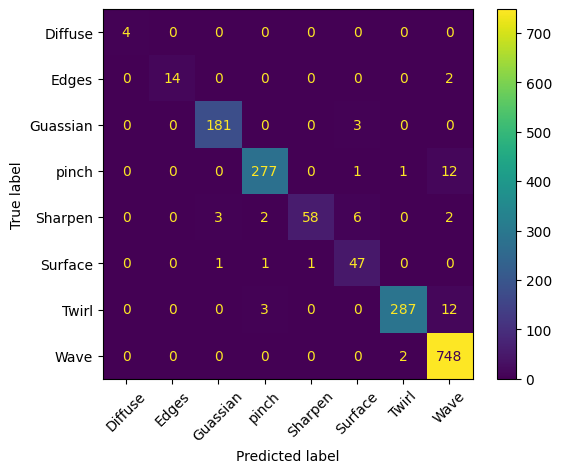

In [56]:
test(test_dataloader, model_retrained_crop, loss_fn)

# Test handmade combo

In [79]:
from torch.utils.data import random_split

path_pair_img = 'Photoshop/data/photoshoptest_handmade'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=None)


test_dataloader = torch.utils.data.DataLoader(dataset, batch_size= 100, shuffle= False)

y_true = []
y_pred = []

for img, y in dataset : 
    
    img_org, img_edt = np.hsplit(np.array(img), 2)
    
    final_imgs = find_bb(img_org, img_edt)
    
    class_small_bb = [0, 0, 0, 0, 0, 0, 0, 0]

    for final_img in final_imgs : 
        image_tensor = image_transform(Image.fromarray(final_img)).unsqueeze(0)
        image_tensor = image_tensor.cuda()

        with torch.no_grad() : 
            output = model_crop(image_tensor)
        _, predicted_class_crop = torch.max(output, 1)
        class_small_bb[predicted_class_crop] += 1
    
    predicted_class_crop = np.argmax(class_small_bb)

    image_tensor = image_transform(img).unsqueeze(0)
    image_tensor = image_tensor.cuda()
    with torch.no_grad() : 
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    if (predicted_class_crop == predicted_class) : 
        y_true.append(y)
        y_pred.append(predicted_class.item())


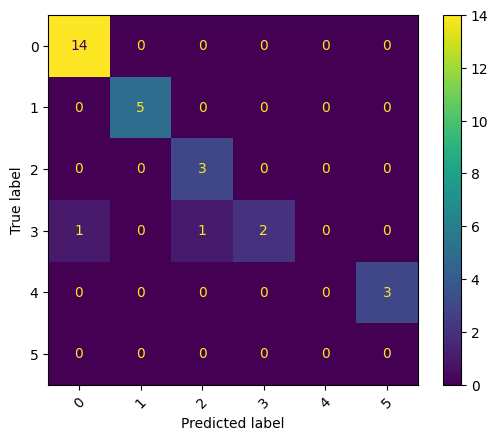

In [80]:
conf_matrix = confusion_matrix(y_true, y_pred)

# labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
from torch.utils.data import random_split

path_pair_img = 'Photoshop/data/photoshoptest_handmade'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=None)


y_true = []
y_pred = []

for img, y in dataset : 
    
    img_org, img_edt = np.hsplit(np.array(img), 2)
    
    final_imgs = find_bb(img_org, img_edt)
    
    class_small_bb = [0, 0, 0, 0, 0, 0, 0, 0]

    for final_img in final_imgs : 
        image_tensor = image_transform(Image.fromarray(final_img)).unsqueeze(0)
        image_tensor = image_tensor.cuda()

        with torch.no_grad() : 
            output = model_retrained_crop(image_tensor)
        _, predicted_class_crop = torch.max(output, 1)
        class_small_bb[predicted_class_crop] += 1
    
    predicted_class_crop = np.argmax(class_small_bb)

    image_tensor = image_transform(img).unsqueeze(0)
    image_tensor = image_tensor.cuda()
    with torch.no_grad() : 
        output = model_retrained(image_tensor)
    _, predicted_class = torch.max(output, 1)

    if (predicted_class_crop == predicted_class) : 
        print((y, predicted_class.item()))
        y_true.append(y)
        y_pred.append(predicted_class.item())


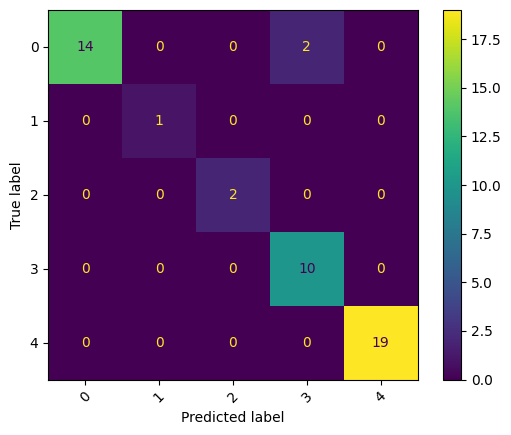

In [93]:
conf_matrix = confusion_matrix(y_true, y_pred)

# labels = ["Diffuse", "Edges", "Guassian", "pinch", "Sharpen", "Surface", "Twirl", "Wave"]
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.xticks(rotation = 45) 
plt.show()

# Retrain the models on hand made data

In [12]:
path_pair_img = 'Photoshop/data/photoshoptest_handmade'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
epochs = 20
torch.cuda.empty_cache()

for i in range(1):
    model_retrained = LeNet().to(device)
    model_retrained.load_state_dict(torch.load("./model"))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        
    print("Done!")

Epoch 1
-------------------------------
loss: 2.539725  [    5/  121]
Epoch 2
-------------------------------
loss: 1.106853  [    5/  121]
Epoch 3
-------------------------------
loss: 1.009493  [    5/  121]
Epoch 4
-------------------------------
loss: 0.354740  [    5/  121]
Epoch 5
-------------------------------
loss: 0.460454  [    5/  121]
Epoch 6
-------------------------------
loss: 0.167663  [    5/  121]
Epoch 7
-------------------------------
loss: 0.064597  [    5/  121]
Epoch 8
-------------------------------
loss: 0.123374  [    5/  121]
Epoch 9
-------------------------------
loss: 0.174234  [    5/  121]
Epoch 10
-------------------------------
loss: 0.349117  [    5/  121]
Epoch 11
-------------------------------
loss: 0.003090  [    5/  121]
Epoch 12
-------------------------------
loss: 0.235433  [    5/  121]
Epoch 13
-------------------------------
loss: 0.005739  [    5/  121]
Epoch 14
-------------------------------
loss: 0.389307  [    5/  121]
Epoch 15
------

In [16]:
torch.save(model.state_dict(), "./model_retrain")

In [18]:
path_pair_img = 'Photoshop/data/photoshoptest_handmade_crop'

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=path_pair_img, transform=image_transform)

batch_size = 5
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [19]:
epochs = 20
torch.cuda.empty_cache()

for i in range(1):
    model_retrained_crop = LeNet().to(device)
    model_retrained_crop.load_state_dict(torch.load("./model_crop"))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        
    print("Done!")

Epoch 1
-------------------------------
loss: 1.415522  [    5/ 1668]
loss: 0.016503  [  505/ 1668]
loss: 0.746076  [ 1005/ 1668]
loss: 0.972595  [ 1505/ 1668]
Epoch 2
-------------------------------
loss: 0.183563  [    5/ 1668]
loss: 0.169295  [  505/ 1668]
loss: 0.897157  [ 1005/ 1668]
loss: 0.373765  [ 1505/ 1668]
Epoch 3
-------------------------------
loss: 0.171020  [    5/ 1668]
loss: 0.525811  [  505/ 1668]
loss: 0.237393  [ 1005/ 1668]
loss: 0.692315  [ 1505/ 1668]
Epoch 4
-------------------------------
loss: 0.496161  [    5/ 1668]
loss: 0.048044  [  505/ 1668]
loss: 0.101526  [ 1005/ 1668]
loss: 0.197519  [ 1505/ 1668]
Epoch 5
-------------------------------
loss: 0.003498  [    5/ 1668]
loss: 0.421855  [  505/ 1668]
loss: 0.017531  [ 1005/ 1668]
loss: 0.288194  [ 1505/ 1668]
Epoch 6
-------------------------------
loss: 0.478498  [    5/ 1668]
loss: 0.165296  [  505/ 1668]
loss: 0.041530  [ 1005/ 1668]
loss: 0.338797  [ 1505/ 1668]
Epoch 7
-------------------------------


In [20]:
torch.save(model.state_dict(), "./model_retrain_crop")